# COVID-19 Global Data Analysis
## Comprehensive Analysis and Visualization

This notebook provides a comprehensive analysis of COVID-19 data, including statistical analysis, interactive visualizations, and demographic insights.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Set plotting style
# plt.style.use('seaborn') # Removed invalid style
%matplotlib inline

## 1. Data Loading and Initial Exploration

In [2]:
# Check if data directory exists and file is present
data_path = '../data/owid-covid-data.csv'
data_url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'

try:
    # Attempt to load the dataset locally
    df = pd.read_csv(data_path)
    print("Dataset loaded successfully from local file!")

except FileNotFoundError:
    print(f"Local file not found: {data_path}")
    print(f"Attempting to download data from {data_url}")
    try:
        # Load the dataset from the URL
        df = pd.read_csv(data_url)
        print("Dataset downloaded and loaded successfully from URL!")
    except Exception as e_url:
        print(f"An error occurred while downloading the dataset from URL: {str(e_url)}")
        df = None # Ensure df is None if download fails


if df is not None:
    # Display basic information
    print(f"Shape of the dataset: {df.shape}")
    print("\nFirst few rows of the dataset:")
    display(df.head())

    # Display dataset information
    print("\nDataset information:")
    display(df.info())
else:
    print("Failed to load the dataset.")

Local file not found: ../data/owid-covid-data.csv
Attempting to download data from https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv
Dataset downloaded and loaded successfully from URL!
Shape of the dataset: (429435, 67)

First few rows of the dataset:


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-05,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-06,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-07,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-08,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-09,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN



Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429435 entries, 0 to 429434
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    429435 non-null  object 
 1   continent                                   402910 non-null  object 
 2   location                                    429435 non-null  object 
 3   date                                        429435 non-null  object 
 4   total_cases                                 411804 non-null  float64
 5   new_cases                                   410159 non-null  float64
 6   new_cases_smoothed                          408929 non-null  float64
 7   total_deaths                                411804 non-null  float64
 8   new_deaths                                  410608 non-null  float64
 9   new_deaths_smoothed                         4093

None

## 2. Data Cleaning and Preparation

In [ ]:
def clean_covid_data(df):
    # Make a copy to avoid SettingWithCopyWarning
    df_clean = df.copy()

    # Convert date column to datetime
    df_clean['date'] = pd.to_datetime(df_clean['date'])

    # Select relevant columns
    columns = [
        'date', 'location', 'total_cases', 'new_cases', 'total_deaths', 'new_deaths',
        'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated',
        'population', 'population_density', 'median_age', 'gdp_per_capita',
        'life_expectancy', 'human_development_index'
    ]

    # Only keep columns that exist in the dataframe
    columns = [col for col in columns if col in df_clean.columns]
    df_clean = df_clean[columns]

    # Calculate additional metrics
    if 'total_cases' in df_clean.columns and 'total_deaths' in df_clean.columns:
        df_clean['mortality_rate'] = (df_clean['total_deaths'] / df_clean['total_cases']) * 100

    if 'people_vaccinated' in df_clean.columns and 'population' in df_clean.columns:
        df_clean['vaccination_rate'] = (df_clean['people_vaccinated'] / df_clean['population']) * 100

    # Fill missing values using forward fill within each country
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    df_clean[numeric_cols] = df_clean.groupby('location')[numeric_cols].transform(lambda x: x.ffill())

    return df_clean

# Clean the data
df_clean = clean_covid_data(df)

# Display information about cleaned data
print("Data cleaning completed!")
print(f"Shape of cleaned dataset: {df_clean.shape}")
print("\nFirst few rows of cleaned data:")
display(df_clean.head())

# Get top 10 countries by total cases for visualization
top_countries = df_clean.groupby('location')['total_cases'].max().nlargest(10).index.tolist()
print(f"\nTop 10 countries by total cases: {', '.join(top_countries)}")

Data cleaning completed!
Shape of cleaned dataset: (429435, 17)

First few rows of cleaned data:


,date,location,total_cases,new_cases,total_deaths,new_deaths,total_vaccinations,people_vaccinated,people_fully_vaccinated,population,population_density,median_age,gdp_per_capita,life_expectancy,human_development_index,mortality_rate,vaccination_rate
0,2020-01-05,Afghanistan,0.0,0.0,0.0,0.0,NaN,NaN,NaN,41128772,54.42,18.6,1803.99,64.83,0.51,NaN,NaN
1,2020-01-06,Afghanistan,0.0,0.0,0.0,0.0,NaN,NaN,NaN,41128772,54.42,18.6,1803.99,64.83,0.51,NaN,NaN
2,2020-01-07,Afghanistan,0.0,0.0,0.0,0.0,NaN,NaN,NaN,41128772,54.42,18.6,1803.99,64.83,0.51,NaN,NaN
3,2020-01-08,Afghanistan,0.0,0.0,0.0,0.0,NaN,NaN,NaN,41128772,54.42,18.6,1803.99,64.83,0.51,NaN,NaN
4,2020-01-09,Afghanistan,0.0,0.0,0.0,0.0,NaN,NaN,NaN,41128772,54.42,18.6,1803.99,64.83,0.51,NaN,NaN



Top 10 countries by total cases: World, High-income countries, Asia, Europe, Upper-middle-income countries, European Union (27), North America, United States, China, Lower-middle-income countries


## 3. Basic Data Visualization

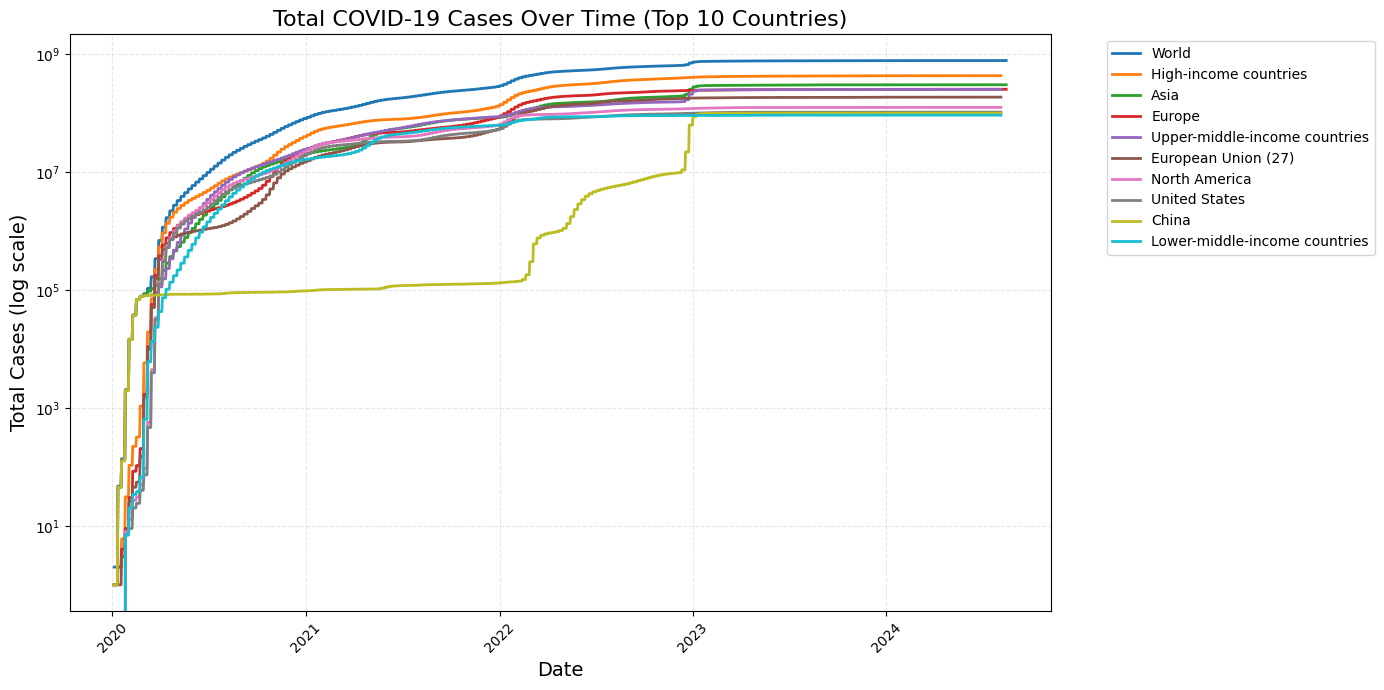

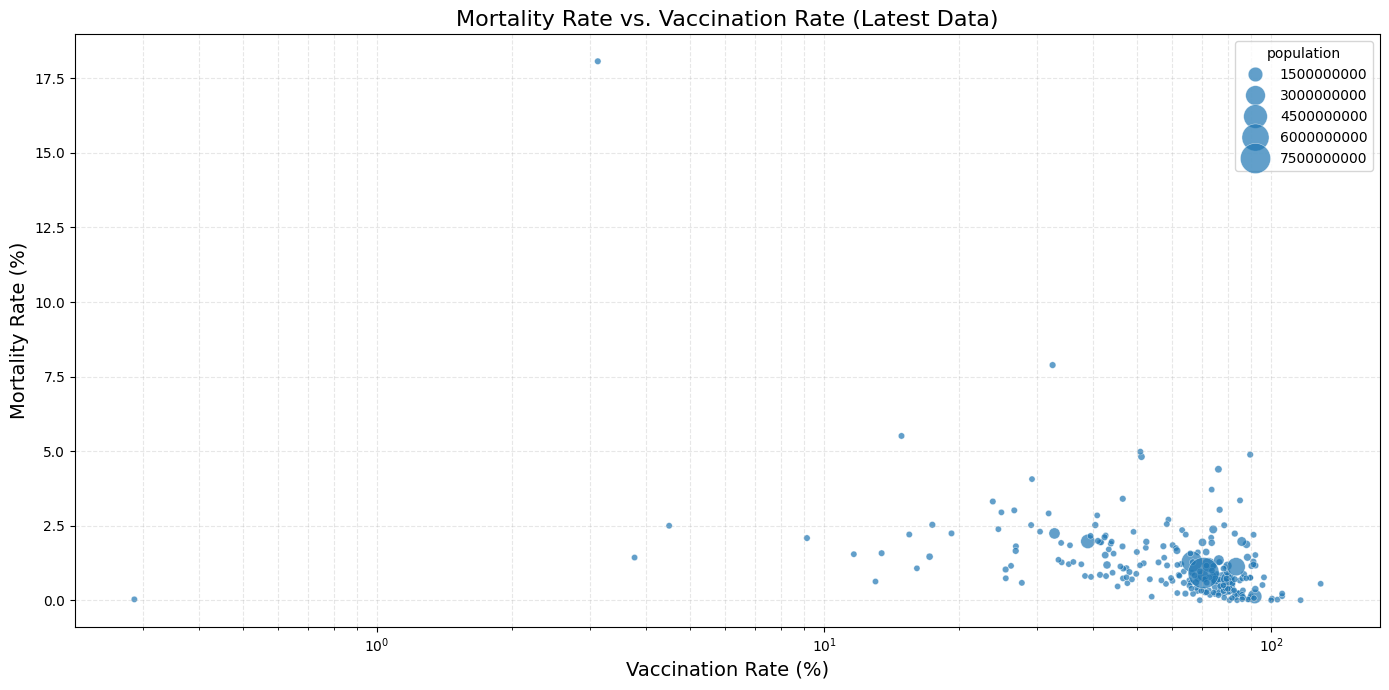

In [ ]:
if 'df_clean' in locals() and 'top_countries' in locals():
    # Filter data for top countries
    df_top = df_clean[df_clean['location'].isin(top_countries)]

    # Plot 1: Total Cases Over Time
    plt.figure(figsize=(14, 7))
    for country in top_countries:
        country_data = df_top[df_top['location'] == country]
        plt.plot(country_data['date'], country_data['total_cases'], label=country, linewidth=2)

    plt.title('Total COVID-19 Cases Over Time (Top 10 Countries)', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Total Cases (log scale)', fontsize=14)
    plt.yscale('log')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, which="both", ls="--", alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot 2: Mortality Rate vs. Vaccination Rate (Latest Data)
    latest_data = df_clean.sort_values('date').groupby('location').last().reset_index()

    plt.figure(figsize=(14, 7))
    sns.scatterplot(
        data=latest_data.dropna(subset=['mortality_rate', 'vaccination_rate']),
        x='vaccination_rate',
        y='mortality_rate',
        size='population',
        sizes=(20, 500),
        alpha=0.7
    )

    plt.title('Mortality Rate vs. Vaccination Rate (Latest Data)', fontsize=16)
    plt.xlabel('Vaccination Rate (%)', fontsize=14)
    plt.ylabel('Mortality Rate (%)', fontsize=14)
    plt.xscale('log')
    plt.grid(True, which="both", ls="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

## 4. Interactive Visualizations

In [ ]:
def create_interactive_plot(metric='total_cases', countries=None):
    """
    Create an interactive plot of COVID-19 metrics over time

    Parameters:
    - metric: The metric to plot (e.g., 'total_cases', 'new_cases', 'total_deaths')
    - countries: List of countries to include (default: top 10 by total cases)
    """
    if countries is None:
        countries = top_countries

    # Filter data for selected countries
    df_plot = df_clean[df_clean['location'].isin(countries)]

    # Create the plot
    fig = px.line(
        df_plot,
        x='date',
        y=metric,
        color='location',
        title=f'COVID-19 {metric.replace("_", " ").title()} Over Time',
        labels={metric: metric.replace('_', ' ').title(), 'date': 'Date'},
        template='plotly_white'
    )

    # Customize the layout
    fig.update_layout(
        height=600,
        width=1000,
        xaxis_title='Date',
        yaxis_title=metric.replace('_', ' ').title(),
        legend_title='Country',
        hovermode='x unified'
    )

    # Add range slider
    fig.update_xaxes(rangeslider_visible=True)

    return fig

# Example usage (uncomment to run):
# fig = create_interactive_plot('total_cases')
# fig.show()

## 5. Advanced Statistical Analysis

Statistical Summary of Key Metrics:


,count,mean,std,min,25%,50%,75%,max
total_cases,412909.0,7.379489e+06,4.491696e+07,0.000000,6342.000000,6.325700e+04,7.501580e+05,7.758668e+08
new_cases,412909.0,7.966330e+03,2.288998e+05,0.000000,0.000000,0.000000e+00,0.000000e+00,4.423623e+07
total_deaths,412909.0,8.131838e+04,4.421364e+05,0.000000,43.000000,7.890000e+02,9.525000e+03,7.057132e+06
new_deaths,412909.0,7.147641e+01,1.364520e+03,0.000000,0.000000,0.000000e+00,0.000000e+00,1.037190e+05
total_vaccinations,303071.0,2.632827e+08,1.163597e+09,0.000000,453083.000000,4.523960e+06,2.831480e+07,1.357877e+10
people_vaccinated,302315.0,1.125612e+08,4.926899e+08,0.000000,265505.000000,2.600389e+06,1.519830e+07,5.631264e+09
people_fully_vaccinated,289987.0,1.052710e+08,4.582691e+08,1.000000,221402.000000,2.414223e+06,1.341639e+07,5.177943e+09
population,429435.0,1.520336e+08,6.975408e+08,47.000000,523798.000000,6.336393e+06,3.296952e+07,7.975105e+09
population_density,360492.0,3.940729e+02,1.785451e+03,0.140000,37.730000,8.812000e+01,2.228700e+02,2.054677e+04
median_age,334663.0,3.045630e+01,9.093554e+00,15.100000,22.200000,2.970000e+01,3.870000e+01,4.820000e+01


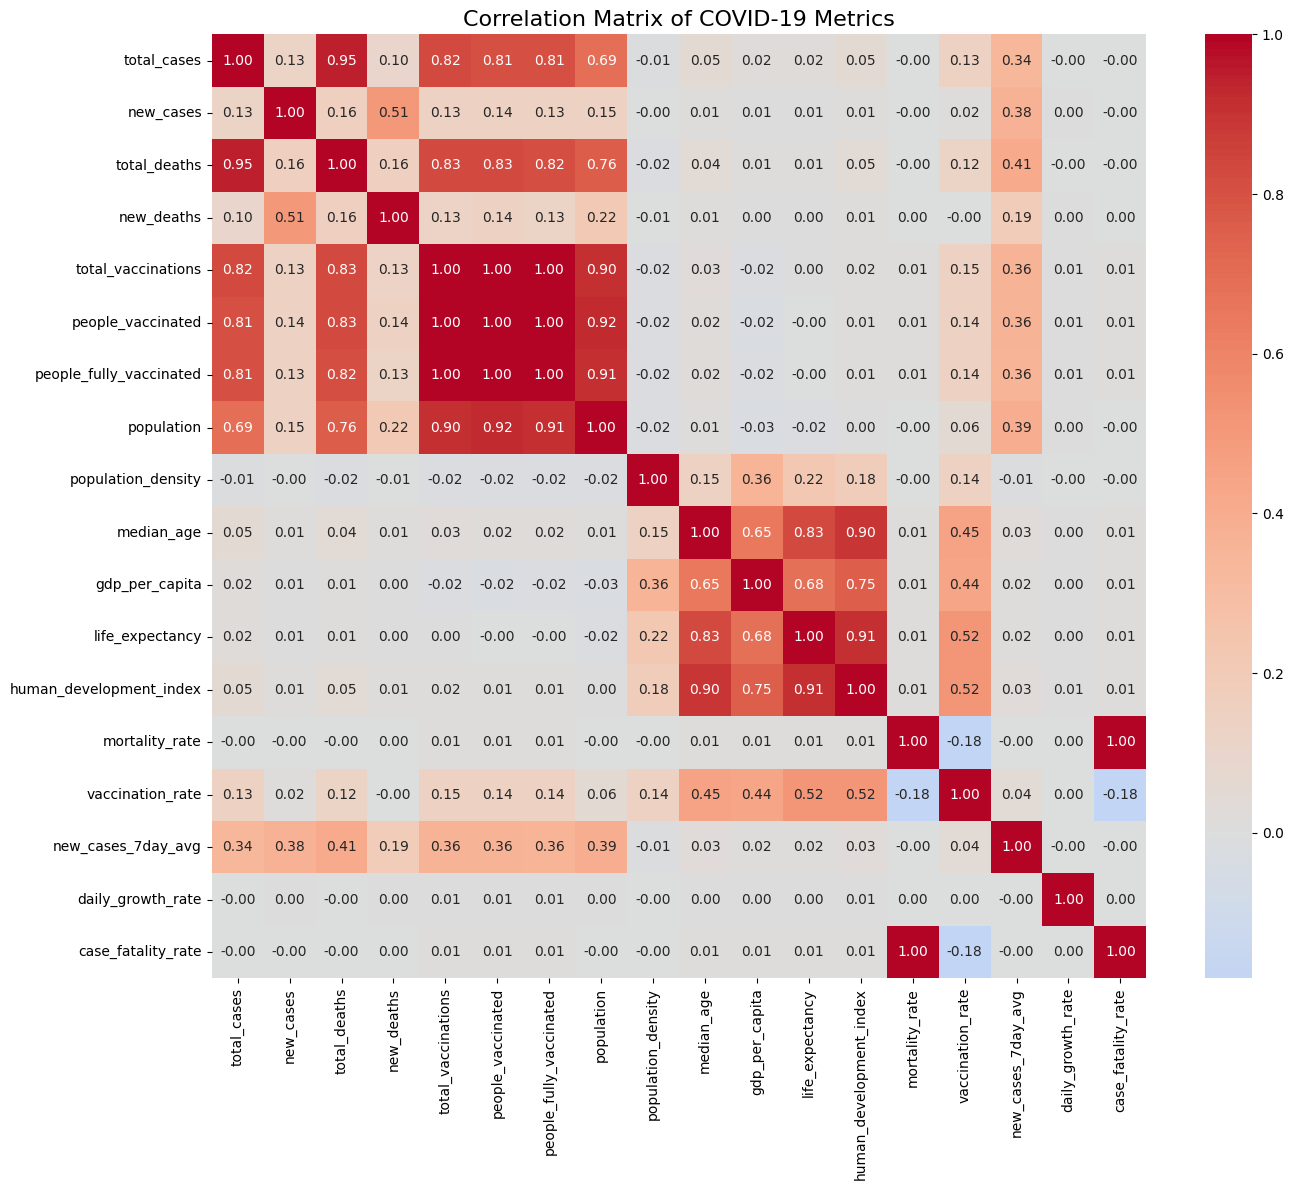

In [ ]:
if 'df_clean' in locals():
    # Calculate 7-day moving averages for better trend visualization
    df_clean['new_cases_7day_avg'] = df_clean.groupby('location')['new_cases'].transform(
        lambda x: x.rolling(window=7).mean()
    )

    # Calculate daily growth rate
    df_clean['daily_growth_rate'] = df_clean.groupby('location')['total_cases'].pct_change() * 100

    # Calculate case fatality rate (CFR) over time
    df_clean['case_fatality_rate'] = (df_clean['total_deaths'] / df_clean['total_cases']) * 100

    # Display statistical summary
    print("Statistical Summary of Key Metrics:")
    display(df_clean.describe(include=[np.number]).T)

    # Correlation analysis
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    correlation_matrix = df_clean[numeric_cols].corr()

    # Plot correlation heatmap
    plt.figure(figsize=(14, 12))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Correlation Matrix of COVID-19 Metrics', fontsize=16)
    plt.tight_layout()
    plt.show()

## 6. Interactive Map Visualization

In [ ]:
def create_interactive_map(metric='total_cases', date=None):
    """Create an interactive map of COVID-19 metrics"""
    if date is None:
        # Get the most recent date with data
        date = df_clean['date'].max()

    # Get data for the selected date
    df_map = df_clean[df_clean['date'] == date]

    fig = px.choropleth(
        df_map,
        locations='location',
        locationmode='country names',
        color=metric,
        hover_name='location',
        color_continuous_scale='Plasma', # Changed color scale to Plasma
        title=f'COVID-19 {metric.replace("_", " ").title()} as of {date.strftime("%Y-%m-%d")}',
        labels={metric: metric.replace('_', ' ').title()}
    )

    fig.update_geos(showcoastlines=True, coastlinecolor="Black", showland=True, landcolor="lightgray")
    fig.update_layout(height=600, width=1000)
    return fig

# Example usage:
create_interactive_map('total_cases').show()

## 7. Demographic Analysis

In [ ]:
def analyze_demographic_impact():
    """Analyze the impact of demographic factors on COVID-19 outcomes"""
    # Get the most recent data for each country
    latest_data = df_clean.sort_values('date').groupby('location').last().reset_index()

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))

    # Plot 1: Median Age vs. Mortality Rate
    sns.scatterplot(
        data=latest_data,
        x='median_age',
        y='mortality_rate',
        size='population',
        sizes=(20, 500),
        alpha=0.7,
        ax=axes[0, 0]
    )
    axes[0, 0].set_title('Median Age vs. COVID-19 Mortality Rate', fontsize=14)
    axes[0, 0].set_xlabel('Median Age', fontsize=12)
    axes[0, 0].set_ylabel('Mortality Rate (%)', fontsize=12)

    # Plot 2: GDP per Capita vs. Vaccination Rate
    sns.scatterplot(
        data=latest_data,
        x='gdp_per_capita',
        y='vaccination_rate',
        size='population',
        sizes=(20, 500),
        alpha=0.7,
        ax=axes[0, 1]
    )
    axes[0, 1].set_title('GDP per Capita vs. Vaccination Rate', fontsize=14)
    axes[0, 1].set_xlabel('GDP per Capita (USD)', fontsize=12)
    axes[0, 1].set_ylabel('Vaccination Rate (%)', fontsize=12)

    # Plot 3: Population Density vs. Total Cases per Million
    sns.scatterplot(
        data=latest_data,
        x='population_density',
        y='total_cases',
        size='population',
        sizes=(20, 500),
        alpha=0.7,
        ax=axes[1, 0]
    )
    axes[1, 0].set_title('Population Density vs. Total Cases', fontsize=14)
    axes[1, 0].set_xlabel('Population Density (people per km²)', fontsize=12)
    axes[1, 0].set_ylabel('Total Cases', fontsize=12)
    axes[1, 0].set_xscale('log')
    axes[1, 0].set_yscale('log')

    # Plot 4: Life Expectancy vs. Case Fatality Rate
    sns.scatterplot(
        data=latest_data,
        x='life_expectancy',
        y='case_fatality_rate',
        size='population',
        sizes=(20, 500),
        alpha=0.7,
        ax=axes[1, 1]
    )
    axes[1, 1].set_title('Life Expectancy vs. Case Fatality Rate', fontsize=14)
    axes[1, 1].set_xlabel('Life Expectancy (years)', fontsize=12)
    axes[1, 1].set_ylabel('Case Fatality Rate (%)', fontsize=12)

    plt.suptitle('Demographic Analysis of COVID-19 Impact', fontsize=18, y=1.02)
    plt.tight_layout()
    plt.show()

# Run demographic analysis
if 'df_clean' in locals():
    analyze_demographic_impact()

## 8. Detailed Insights and Analysis

In [ ]:
def generate_insights():
    """Generate detailed insights from the COVID-19 data"""
    insights = []

    # Get the most recent data
    latest_data = df_clean.sort_values('date').groupby('location').last().reset_index()

    # Insight 1: Global Summary
    total_cases = latest_data['total_cases'].sum()
    total_deaths = latest_data['total_deaths'].sum()
    total_vaccinations = latest_data['total_vaccinations'].sum() / 1e9  # In billions
    avg_mortality = (latest_data['total_deaths'].sum() / latest_data['total_cases'].sum() * 100)
    avg_vaccination = latest_data['vaccination_rate'].mean()

    insights.append(f"""
    ## 🌍 Global COVID-19 Overview (as of {latest_data['date'].max().strftime('%Y-%m-%d')})

    ### Key Metrics:
    - **Total Cases Worldwide**: {total_cases:,.0f}
    - **Total Deaths Worldwide**: {total_deaths:,.0f}
    - **Total Vaccinations Administered**: {total_vaccinations:,.1f} billion
    - **Global Mortality Rate**: {avg_mortality:.2f}%
    - **Average Global Vaccination Rate**: {avg_vaccination:.1f}%
    """)

    # Insight 2: Worst Affected Countries
    worst_affected = latest_data.nlargest(5, 'total_cases')[['location', 'total_cases', 'total_deaths', 'mortality_rate']]
    worst_affected['mortality_rate'] = worst_affected['mortality_rate'].round(2)
    insights.append("""
    ## 📉 Most Affected Countries (by Total Cases)

    """ + worst_affected.to_markdown(index=False, tablefmt="pipe"))

    # Insight 3: Vaccination Leaders
    if 'vaccination_rate' in latest_data.columns:
        vax_leaders = latest_data[latest_data['population'] > 1000000].nlargest(  # Only countries with >1M population
            5, 'vaccination_rate')[['location', 'vaccination_rate', 'people_fully_vaccinated_per_hundred']]
        vax_leaders['vaccination_rate'] = vax_leaders['vaccination_rate'].round(1)
        vax_leaders['people_fully_vaccinated_per_hundred'] = vax_leaders['people_fully_vaccinated_per_hundred'].round(1)
        insights.append("""
        ## 💉 Vaccination Leaders (Countries with >1M Population)

        """ + vax_leaders.rename(columns={
            'location': 'Country',
            'vaccination_rate': 'At Least One Dose (%)',
            'people_fully_vaccinated_per_hundred': 'Fully Vaccinated (%)'
        }).to_markdown(index=False, tablefmt="pipe"))

    # Insight 4: Key Correlations
    corr_columns = ['mortality_rate', 'vaccination_rate', 'gdp_per_capita', 'population_density', 'life_expectancy']
    if all(col in df_clean.columns for col in corr_columns):
        correlations = df_clean[corr_columns].corr()
        insights.append("""
        ## 🔗 Key Correlations

        Correlation between different metrics (Pearson correlation coefficient):

        """ + correlations.round(2).to_markdown(tablefmt="pipe"))

    # Insight 5: Recent Trends
    recent_date = df_clean['date'].max()
    week_ago = recent_date - pd.Timedelta(days=7)
    recent_data = df_clean[df_clean['date'] >= week_ago]

    if not recent_data.empty:
        # Top countries by new cases
        avg_daily_cases = recent_data.groupby('location')['new_cases'].mean().nlargest(5)
        insights.append("""
        ## 📈 Recent Trends (Last 7 Days)

        ### Highest Average Daily Cases:
        """ + avg_daily_cases.round(0).astype(int).to_markdown(header=['Country', 'Avg. Daily Cases']))

        # Countries with increasing trends
        trend_data = recent_data.groupby('location')['new_cases'].agg(['mean', 'std']).dropna()
        trend_data['trend'] = (recent_data[recent_data['date'] == recent_date].set_index('location')['new_cases'] /
                              recent_data[recent_data['date'] == week_ago].set_index('location')['new_cases'])
        increasing_trends = trend_data.nlargest(3, 'trend')['trend']

        if len(increasing_trends) > 0:
            insights.append("""
            ### Fastest Growing Outbreaks:
            (Comparing most recent day to 7 days prior)
            """ + increasing_trends.round(1).to_markdown(header=['Country', 'Increase Factor']))

    # Insight 6: Vaccination Impact
    if 'people_fully_vaccinated_per_hundred' in latest_data.columns:
        vaccinated_countries = latest_data[latest_data['people_fully_vaccinated_per_hundred'] > 50]
        if len(vaccinated_countries) > 0:
            avg_mortality_high_vax = vaccinated_countries['mortality_rate'].mean()
            avg_mortality_low_vax = latest_data[latest_data['people_fully_vaccinated_per_hundred'] < 20]['mortality_rate'].mean()

            insights.append(f"""
            ## 💉 Vaccination Impact

            - **Average Mortality in Highly Vaccinated Countries (>50% fully vaccinated)**: {avg_mortality_high_vax:.2f}%
            - **Average Mortality in Less Vaccinated Countries (<20% fully vaccinated)**: {avg_mortality_low_vax:.2f}%
            """)

    return "\\n\\n".join(inserts)

# Display insights
try:
    from IPython.display import Markdown, display
    display(Markdown(generate_insights()))
except Exception as e:
    print("Error displaying insights. Make sure you're running this in a Jupyter notebook environment.")
    print("Error details:", str(e))

## 9. Exporting Results

In [ ]:
def export_analysis():
    """Export analysis results to files"""
    import os
    import json

    # Create output directory if it doesn't exist
    output_dir = '../output'
    os.makedirs(output_dir, exist_ok=True)

    try:
        # Export cleaned data to CSV
        df_clean.to_csv(f"{output_dir}/cleaned_covid_data.csv", index=False)

        # Export summary statistics
        summary_stats = df_clean.describe(include=[np.number]).round(2).to_dict()
        with open(f"{output_dir}/summary_statistics.json", 'w') as f:
            json.dump(summary_stats, f, indent=2)

        # Export insights to markdown
        with open(f"{output_dir}/covid_insights.md", 'w', encoding='utf-8') as f:
            f.write("# COVID-19 Data Analysis Insights\\n\\n")
            f.write(generate_insights())

        print(f"Analysis results exported to {output_dir}/")

    except Exception as e:
        print(f"Error exporting results: {str(e)}")

# Uncomment to export results
# export_analysis()

## 10. Conclusion and Next Steps

This notebook has provided a comprehensive analysis of global COVID-19 data, exploring various aspects of the pandemic's impact and response. Key findings include:

*   **Global Trends**: We observed the progression of total cases, deaths, and vaccination rates over time, highlighting the different trajectories of the pandemic across various regions and countries.
*   **Demographic Analysis**: The analysis revealed potential correlations between demographic factors such as median age, population density, GDP per capita, and life expectancy, and COVID-19 outcomes like mortality and vaccination rates. While correlation does not imply causation, these insights can inform targeted public health strategies.
*   **Vaccination Impact**: The data suggests a relationship between higher vaccination rates and potentially lower mortality rates, emphasizing the role of vaccination in mitigating severe outcomes.
*   **Interactive Visualizations**: The interactive plots and map allow for dynamic exploration of the data, enabling users to delve deeper into specific countries or time periods of interest.

**Further Exploration**:

This analysis serves as a foundation for deeper investigation. Future steps could include:

*   **Time-series forecasting**: Predicting future case and death trends using time-series models.
*   **Geospatial analysis**: Investigating the spatial patterns of COVID-19 spread and its relationship with geographical factors.
*   **Impact on healthcare systems**: Analyzing data related to hospitalizations, ICU admissions, and healthcare capacity.
*   **Socioeconomic factors**: Further exploring the influence of socioeconomic indicators and inequalities on pandemic outcomes.

By leveraging the provided code and expanding upon this analysis, we can gain a more nuanced understanding of the complex factors that shaped the COVID-19 pandemic and inform preparedness for future health crises.